### Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from snntorch import functional as SF

import torch, torchvision, os, time

from Analog2SpikeDataset import SpikeDataset
from torch.utils.data import DataLoader

from utils import create_results_dir
from LIF import LIFlayer
import torch.nn as nn

from Monitors import SpikeMonitor, StateMonitor

In [16]:
if torch.cuda.is_available():               # check GPU availability
    device = torch.device('cuda')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

In [17]:
batch_size = 64
num_steps = 50
spk_thr = 0.35
num_epochs = 20
lr = 1e-3
root = 'datasets'

In [18]:
model_path = create_results_dir()

### Data Loading

In [19]:
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

train_spks = SpikeDataset(train_dataset, num_steps=num_steps)
test_spks = SpikeDataset(test_dataset, num_steps=num_steps)

train_loader = DataLoader(train_spks, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_spks, batch_size=batch_size, shuffle=True, drop_last=True)

### Conv. SNN Model (Avg. Pooling)

In [20]:
class CSNN(nn.Module):
    def __init__(self, input_size: tuple, batch_size=128, spk_threshold=1.0, k=25.0):
        super().__init__()

        self.k = k                      # slope of the surrogate gradient function
        self.batch_size = batch_size

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
        self.lif1 = LIFlayer(threshold=spk_threshold)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=1)

        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
        self.lif2 = LIFlayer(threshold=spk_threshold)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=1)

        conv1_os = CSNN.conv_output_size(input_size=input_size, conv_st=1, conv_pd=0, conv_ks=2, poo_ks=2, poo_st=1)
        conv2_os = CSNN.conv_output_size(input_size=conv1_os, conv_st=1, conv_pd=0, conv_ks=2, poo_ks=2, poo_st=1)
        self.fc_input_size = 1*conv2_os[0]*conv2_os[1]

        self.fc1 = nn.Linear(self.fc_input_size, 10, bias=False)
        self.lif3 = LIFlayer(threshold=spk_threshold)

    def reset_states(self):
        """ Access all LIF layers and reset membrane state tensors. """
        self.lif1.reset_mem()
        self.lif2.reset_mem()
        self.lif3.reset_mem()

    def forward(self, x):
        """ Forward pass on input tensor(s). """

        out = self.conv1(x)
        spk1, mem1 = self.lif1(out, self.k)
        out1 = self.avgpool1(spk1)

        out2 = self.conv2(out1)
        spk2, mem2 = self.lif2(out2, self.k)
        out2 = self.avgpool2(spk2)

        out3 = out2.view(self.batch_size, -1)

        out3 = self.fc1(out3)
        spk3, mem3 = self.lif3(out3, self.k)

        return spk1, mem1, spk2, mem2, spk3, mem3
    
    @staticmethod
    def forward_pass_static(net, data, num_steps=100):
        """ Same input fed at every time step. """
        mem_out_rec = []
        spk_out_rec = []
        spk_1_rec = []
        mem_1_rec = []
        spk_2_rec = []
        mem_2_rec = []

        net.reset_states()                                 # resets hidden states for all LIF neurons in net

        for step in range(num_steps):
            spk1, mem1, spk2, mem2, spk_out, mem_out = net.forward(data)
            spk_out_rec.append(spk_out)
            mem_out_rec.append(mem_out)

            spk_1_rec.append(spk1)
            mem_1_rec.append(mem1)
            spk_2_rec.append(spk2)
            mem_2_rec.append(mem2)

        return torch.stack(spk_1_rec), torch.stack(mem_1_rec), \
            torch.stack(spk_2_rec), torch.stack(mem_2_rec), \
                torch.stack(spk_out_rec), torch.stack(mem_out_rec)
    
    @staticmethod
    def forward_pass_spikes(net, data, num_steps):
        """ Input has different values for different time steps. """
        mem_out_rec = []
        spk_out_rec = []
        spk_1_rec = []
        mem_1_rec = []
        spk_2_rec = []
        mem_2_rec = []
        net.reset_states()                                              # resets hidden states for all LIF neurons in net

        for step in range(num_steps):
            spk1, mem1, spk2, mem2, spk_out, mem_out = net.forward(data[:, step:step+1, :, :])  # feed each time step sequentially

            spk_out_rec.append(spk_out)
            mem_out_rec.append(mem_out)

            spk_1_rec.append(spk1)
            mem_1_rec.append(mem1)
            spk_2_rec.append(spk2)
            mem_2_rec.append(mem2)

        return torch.stack(spk_1_rec), torch.stack(mem_1_rec), \
            torch.stack(spk_2_rec), torch.stack(mem_2_rec), \
                torch.stack(spk_out_rec), torch.stack(mem_out_rec)

    @staticmethod
    def conv_output_size(input_size, conv_st, conv_pd, conv_ks, poo_ks, poo_st):
        """ Calculate the output size after convolutional and max pooling layers. """
        conv_output_size = [(size + 2 * conv_pd - conv_ks) // conv_st + 1 for size in input_size]   # xonvolution with padding=1 and stride=1
        pool_output_size = [(size - poo_ks) // poo_st + 1 for size in conv_output_size]             # max pooling with size=2 and stride=1
        return pool_output_size

In [21]:
model = CSNN(input_size=(28,28), batch_size=batch_size, spk_threshold=spk_thr).to(device)

### Loss and Optimizer

In [22]:
loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

### Training the model

In [23]:
def batch_accuracy(model, data_loader, device, num_steps):
    ''' Returns the accuracy on the entire DataLoader object. '''
    with torch.no_grad():
        total = 0
        acc = 0
        model.eval()

        data_loader = iter(data_loader)
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk1, mem1, spk2, mem2, spk_out, mem_out = CSNN.forward_pass_spikes(model, data, num_steps)

            acc += SF.accuracy_rate(spk_out, targets) * spk_out.size(1)
            total += spk_out.size(1)

    return acc/total

In [24]:
epochs = []
losses = []
accuracies = []

for epoch in range(num_epochs):

    epochs.append(epoch)
    epochloss = 0
    counter = 0

    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        model.train()
        spk1, mem1, spk2, mem2, spk_out, mem_out = CSNN.forward_pass_spikes(model, data, num_steps)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_out, targets.long())

        # gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epochloss += loss_val.item()
        counter += 1
    
    epochloss = epochloss/counter
    losses.append(epochloss)

    with torch.no_grad():
        model.eval()
        test_acc = batch_accuracy(model, test_loader, device, num_steps)
        accuracies.append(test_acc)

    print(f'epoch: {epoch}, loss: {epochloss}, test accu.: {test_acc}')

epoch: 0, loss: 2.302583694458008, test accu.: 0.0
epoch: 1, loss: 2.302583694458008, test accu.: 0.0
epoch: 2, loss: 2.302583694458008, test accu.: 0.0
epoch: 3, loss: 2.302583694458008, test accu.: 0.0
epoch: 4, loss: 2.302583694458008, test accu.: 0.0
epoch: 5, loss: 2.302583694458008, test accu.: 0.0
epoch: 6, loss: 2.302583694458008, test accu.: 0.0
epoch: 7, loss: 2.302583694458008, test accu.: 0.0
epoch: 8, loss: 2.302583694458008, test accu.: 0.0
epoch: 9, loss: 2.302583694458008, test accu.: 0.0
epoch: 10, loss: 2.302583694458008, test accu.: 0.0
epoch: 11, loss: 2.302583694458008, test accu.: 0.0
epoch: 12, loss: 2.302583694458008, test accu.: 0.0
epoch: 13, loss: 2.302583694458008, test accu.: 0.0
epoch: 14, loss: 2.302583694458008, test accu.: 0.0
epoch: 15, loss: 2.302583694458008, test accu.: 0.0
epoch: 16, loss: 2.302583694458008, test accu.: 0.0
epoch: 17, loss: 2.302583694458008, test accu.: 0.0
epoch: 18, loss: 2.302583694458008, test accu.: 0.0
epoch: 19, loss: 2.302

### Plotting results

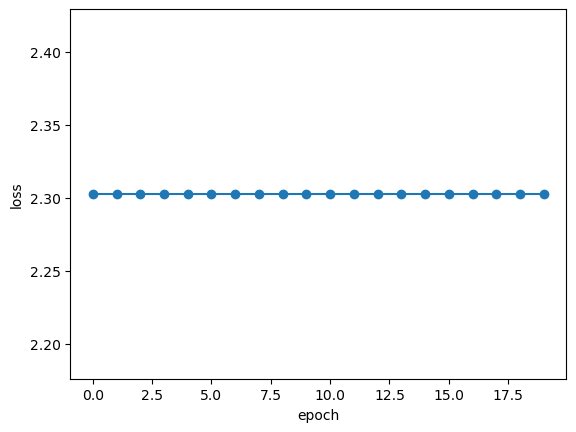

In [25]:
plt.plot(epochs, losses, '-o')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

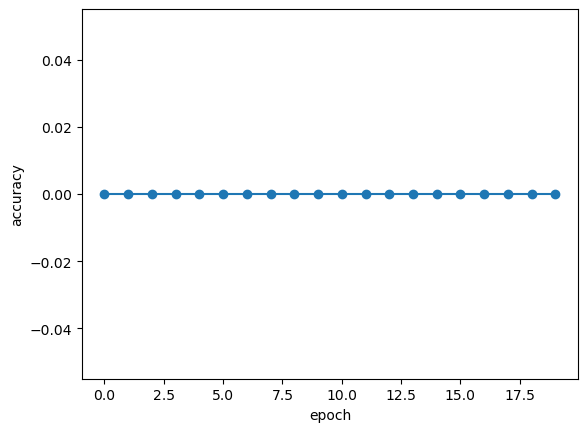

In [26]:
plt.plot(epochs, accuracies, '-o')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### Seeing Network Activity

In [27]:
with torch.no_grad():
    model.eval()
    batch_counter = 0

    print('plottting...')

    for data, targets in iter(test_loader):
        data = data.to(device)
        targets = targets.to(device)

        model.train()
        spk1, mem1, spk2, mem2, spk_out, mem_out = CSNN.forward_pass_spikes(model, data, num_steps)

        mem1_mon = StateMonitor(mem1, spk_thr, 'SpkConv1')
        mem1_mon.sample_membranes(path=model_path)
        mem1_mon.plot_layer(plot=True, path=model_path) 

        spk1_mon = SpikeMonitor(spk1, 'SpkConv1')
        spk1_mon.plot_layer(plot=True, path=model_path)

        mem2_mon = StateMonitor(mem2, spk_thr, 'SpkConv2')
        mem2_mon.sample_membranes(path=model_path)
        mem2_mon.plot_layer(plot=True, path=model_path) 

        spk2_mon = SpikeMonitor(spk2, 'SpkConv2')
        spk2_mon.plot_layer(plot=True, path=model_path)

plottting...
sampled-membranes_sampled_mem-SpkConv1_channel_0_sample_0.png
layer-membranes_layer_mem-SpkConv1_channel_0_sample_0.gif
